In [ ]:
Модель и AI взяты отсюда: https://huggingface.co/datasets/dair-ai/emotion

+ https://huggingface.co/Tirendaz/distilbert-emotion

# Загрузка датасета

Загружаем датасет

In [1]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Обзор данных

In [2]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_ds)

16000

In [5]:
train_ds[1]

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'label': 0}

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [9]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

# Преобразование датасета в объекты Pandas

Преобразуем датасет в объекты пандас (как в ДЗ с анализом данных)

In [10]:
import pandas as pd
emotions.set_format(type="pandas")
df=emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Небольшая визуализация данных

Визуализируем данные эмоций

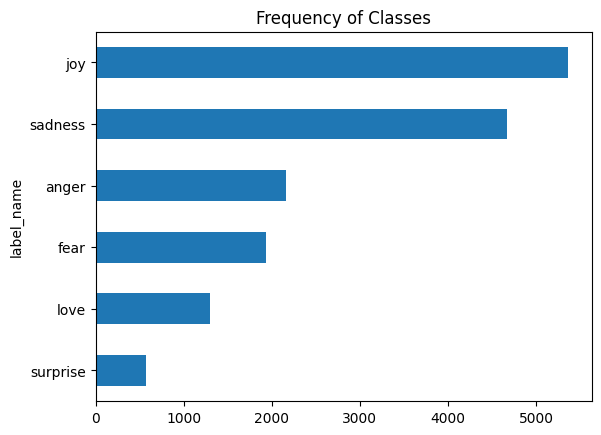

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

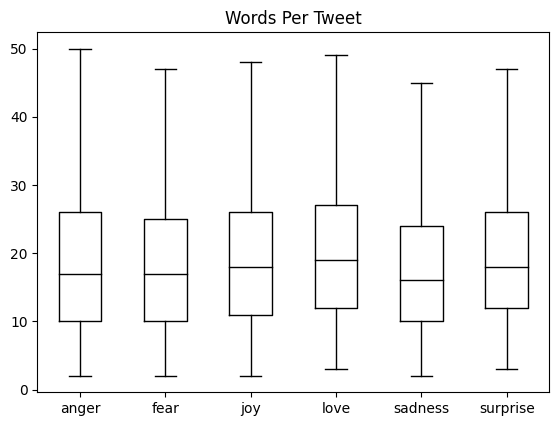

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid = False, showfliers = False,
          color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

# Обучение модели

In [35]:
from transformers import AutoModelForSequenceClassification

num_labels = 6

model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,
         num_labels = num_labels).to("cpu")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Исполнение

In [36]:
!pip install -qU evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, 
                           references = labels)

# Авторизация в HuggingFace

In [38]:
from huggingface_hub import notebook_login
notebook_login()

# Инициализация аргументов обучения модели

In [39]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="distilbert-emotion",
    num_train_epochs = 2, 
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "none"    
)

In [40]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer,
)

In [41]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.224890,0.925500
2,No log,0.169202,0.932000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=250, training_loss=0.4410989685058594, metrics={'train_runtime': 103.0911, 'train_samples_per_second': 310.405, 'train_steps_per_second': 2.425, 'total_flos': 498311664233472.0, 'train_loss': 0.4410989685058594, 'epoch': 2.0})

# Предсказания модели

In [48]:
from transformers import pipeline

model_id = "Tirendaz/distilbert-emotion"
classifier = pipeline("text-classification", model= model_id)

In [49]:
custom_text="I watched a movie yesterday. It was really good."

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


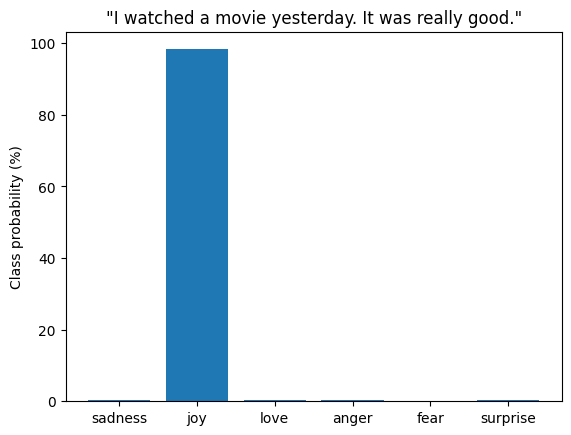

In [50]:
preds=classifier(custom_text, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()